In [2]:
import ultralytics
from PIL import Image

model = ultralytics.YOLO("./data/yolo11/yolo11n.pt")
PIL_IMAGE = Image.Image

In [3]:
cat_and_dog = Image.open("./data/cat_and_dog.webp")
prediction = model.predict(cat_and_dog)[0];


0: 640x640 1 cat, 1 dog, 28.7ms
Speed: 1.9ms preprocess, 28.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


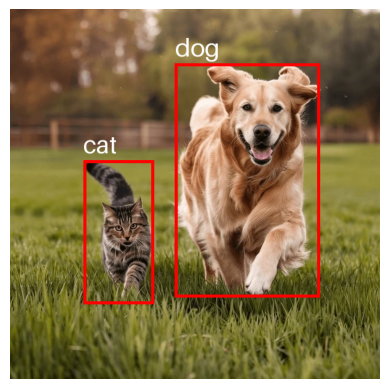

In [4]:
from ultralytics.engine.results import Results as YoloResults
from ultralytics.engine.results import Boxes as YoloBoxes
from copy import deepcopy
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt

def draw_bounding_boxes(original_image: PIL_IMAGE, prediction: YoloResults) -> PIL_IMAGE:
    bounding_boxes = deepcopy(original_image)
    draw = ImageDraw.Draw(bounding_boxes)
    
    for box in prediction.boxes:
        class_name = prediction.names[int(box.cls.item())]
        x, y, w, h = map(int, box.xywh.squeeze())

        font = ImageFont.load_default(size=40)
        draw.text((x - w / 2, y - h / 2 - 50), class_name, font=font)

        draw.rectangle([(x - w / 2, y - h / 2), (x + w / 2, y + h / 2)], outline="red", width=5)
    
    return bounding_boxes

def show_image(img: PIL_IMAGE) -> None:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

show_image(draw_bounding_boxes(cat_and_dog, prediction))

In [5]:
import pandas as pd

metadata_path = "./data/dataset_meta"
food_label = "/m/02wbm"

def prepare_metadata(dataset: str, directory_name: str, max_samples: int):
    annotations = pd.read_csv(f"{metadata_path}/{dataset}_bbox.csv")
    food_annotations = annotations[annotations["LabelName"] == food_label]
    
    unique_images = food_annotations["ImageID"]
    unique_images = unique_images.drop_duplicates(ignore_index=True)

    if max_samples < len(unique_images):
        unique_images = unique_images.sample(max_samples)

    image_list_file = f"{metadata_path}/{dataset}_image_list.txt"
    images_with_prefix = f"{dataset}/" + unique_images
    images_with_prefix.to_csv(image_list_file, index=False, header=False)


    sample_annotations = pd.DataFrame(unique_images).merge(food_annotations, on="ImageID", how="inner")

    for record in sample_annotations.drop_duplicates(ignore_index=True).to_dict(orient="records"):
        img_id = record["ImageID"]
        x1, x2, y1, y2 = record["XMin"], record["XMax"], record["YMin"], record["YMax"]

        x = (x1 + x2) / 2
        y = (y1 + y2) / 2
        w = (x2 - x1)
        h = (y2 - y1)
        
        with open(f"./data/yolo_data/labels/{directory_name}/{img_id}.txt", "a+") as f:
            f.write(f"0 {x} {y} {w} {h}\n")

In [ ]:
prepare_metadata("train", "train", 6000)
prepare_metadata("validation", "val", 2000)
prepare_metadata("test", "test", 2000)

In [24]:
!python ./data/downloader.py "./data/dataset_meta/train_image_list.txt" --download_folder="./data/yolo_data/images/train" --num_processes=50
!python ./data/downloader.py "./data/dataset_meta/validation_image_list.txt" --download_folder="./data/yolo_data/images/val" --num_processes=50
!python ./data/downloader.py "./data/dataset_meta/test_image_list.txt" --download_folder="./data/yolo_data/images/test" --num_processes=50

### Trening YOLO

Trening prowadzony był przez 15 epok z użyciem 6000 zdjęć testowych i 1696 walidacyjnych.

In [ ]:
model = ultralytics.YOLO("./data/yolo11/yolo11n.pt")
model.train(data="./data/yolo_data/data.yaml", epochs=15, device="cuda", single_cls=True)

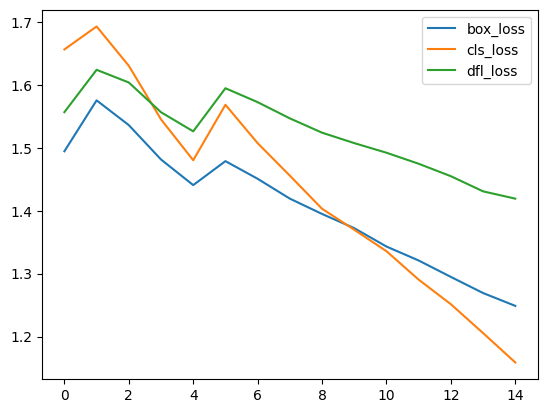

In [8]:
results = pd.read_csv("data/yolo11/results.csv")
box_loss, cls_loss, dfl_loss = results["train/box_loss"], results["train/cls_loss"], results["train/dfl_loss"]

plt.plot(box_loss, label="box_loss")
plt.plot(cls_loss, label="cls_loss")
plt.plot(dfl_loss, label="dfl_loss")
plt.legend()
plt.show();

In [9]:
model = ultralytics.YOLO("data/weights/best.pt")

In [ ]:
import os

test_path = "data/yolo_data/images/test"
test_images_ids = sorted(os.listdir(test_path))
test_images_paths = list(map(lambda x: f"{test_path}/{x}", test_images_ids))
images = list(map(Image.open, test_images_paths[10::150]))
test_images = [images[2], images[12], images[14], images[16], images[33]]

In [11]:
pred = model.predict(test_images)


0: 640x640 2 foods, 128.3ms
1: 640x640 18 foods, 128.3ms
2: 640x640 2 foods, 128.3ms
3: 640x640 3 foods, 128.3ms
4: 640x640 1 food, 128.3ms
Speed: 1.7ms preprocess, 128.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


### Blurowanie

Do rozmycia znalezionych na obrazie boundig boxów używam konwolucji z jednostajnym kernelem, na każdym kanale RGB.

In [12]:
import torch
from torchvision.transforms import v2
import torch.nn.functional as F
from typing import Callable

transforms = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)
])


def blur_channel(channel: torch.Tensor, kernel: torch.Tensor):
    blurred = F.conv2d(channel.unsqueeze(0), kernel)
    return blurred.squeeze()


def take_image_view(
        image: torch.Tensor, 
        box: YoloBoxes, 
        pad_vertical: int, 
        pad_horizontal: int, 
    ) -> torch.Tensor:

    # Jeśli używam stałego paddingu przy konwolucji to na bounding boxie powstają bardzo widoczne krawędzie.
    # Lepiej jest więc przed konwolucją wyciąć większą część obrazka, aby po tej operacji wymiary były znowu takie same.
    # Należy wtedy jednak uwzględnić przypadki, gdy bounding box znajduje się blisko
    # krawędzi obrazka i dodatkowy padding wychodzi poza obraz.
    
    x1, y1, x2, y2 = map(int, box.xyxy.squeeze())
    target_height, target_width = (y2 - y1) + 2*pad_vertical, (x2 - x1) + 2*pad_horizontal

    add_up = -min(y1 - pad_vertical, 0)
    add_down = max(y2 + pad_vertical - image.shape[1], 0)

    add_left = -min(x1 - pad_horizontal, 0)
    add_right = max(x2 + pad_horizontal - image.shape[2], 0)

    y1, y2 = max(y1 - pad_vertical, 0), y2 + pad_vertical
    x1, x2 = max(x1 - pad_horizontal, 0), x2 + pad_horizontal

    max_view = image[:, y1:y2, x1:x2]
    
    padded = torch.einsum("ijk,i->ijk", torch.ones((3, target_height, target_width)), max_view.mean((1, 2)))
    padded[:, add_up:padded.shape[1]-add_down, add_left:padded.shape[2]-add_right] = max_view
    
    return padded

def blur_part_of_image(image: torch.Tensor, box: YoloBoxes) -> None:
    x1, y1, x2, y2 = map(int, box.xyxy.squeeze())

    # Wielkość kernela w stosunku do wielkości bounding boxa
    # decyduje o tym jak bardzo rozmyty jest fragment obrazka
    box_height, box_width = y2 - y1, x2 - x1
    kernel_height, kernel_width = box_height // 7, box_width // 7

    # Lepiej żeby kernel miał nieparzyste wymiary
    kernel_height = kernel_height + kernel_height % 2 + 1
    kernel_width = kernel_width + kernel_width % 2 + 1

    kernel = torch.ones((1, 1, kernel_height, kernel_width))
    kernel /= kernel.sum()

    part_to_blur = take_image_view(image, box, kernel_height // 2, kernel_width // 2)

    # Konwolucja na każdym kanale
    blurred_part = torch.stack([blur_channel(channel, kernel) for channel in part_to_blur])

    image[:, y1:y2, x1:x2] = blurred_part


def blur_image(original_image: PIL_IMAGE, prediction: YoloResults)-> PIL_IMAGE:
    
    img = v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True)
    ])(original_image)

    for box in prediction.boxes:        
        blur_part_of_image(img, box)

    return v2.ToPILImage()(img)

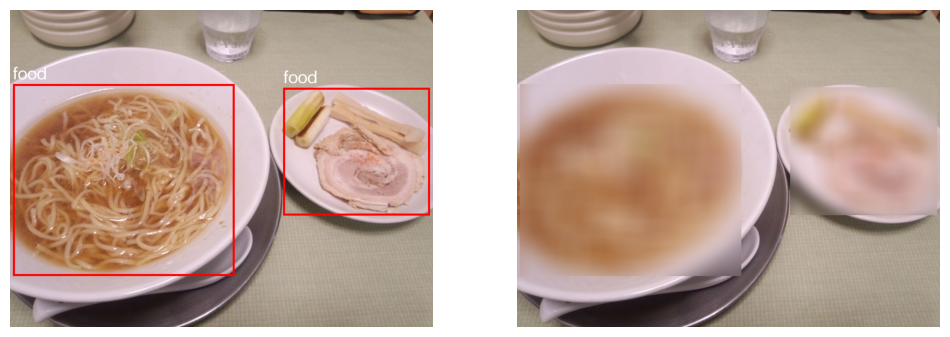

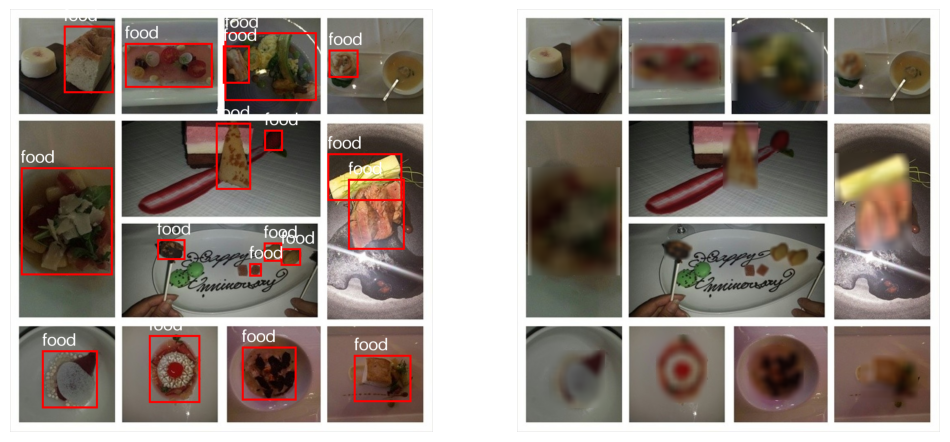

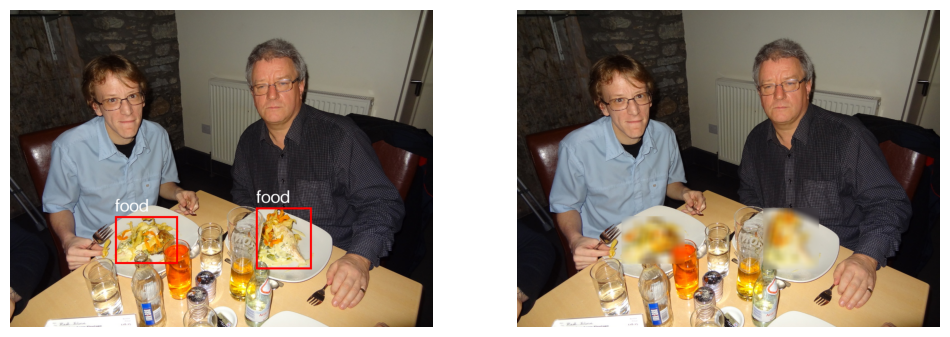

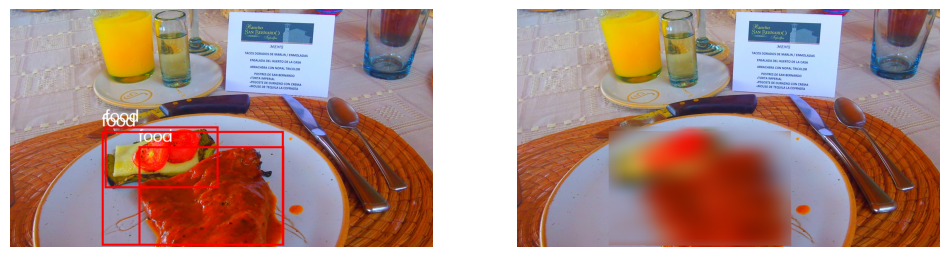

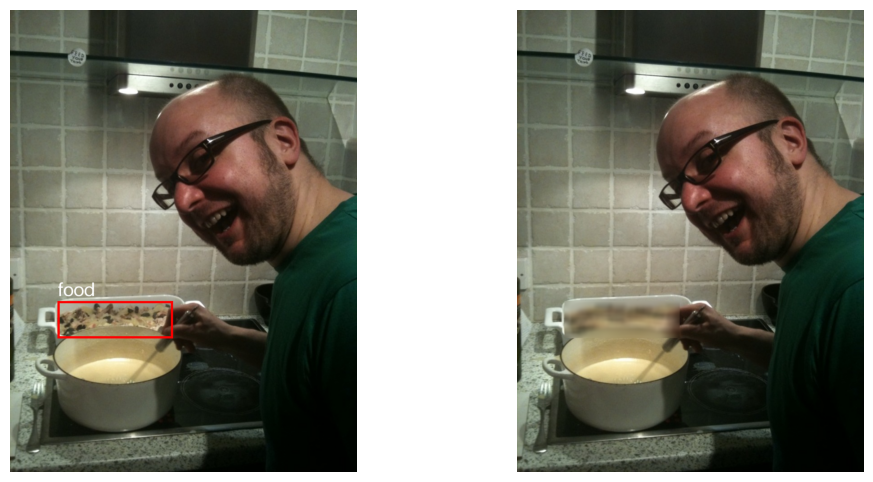

In [13]:
def show_images(*images: tuple[PIL_IMAGE]):
    fig, axis = plt.subplots(1, len(images))
    fig.set_size_inches(12, 6)
    for ax, img in zip(axis, images):
        ax.imshow(img)
        ax.axis("off")

for img, prediction_data in zip(test_images, pred):
    bounding_box = draw_bounding_boxes(img, prediction_data)
    blurred = blur_image(img, prediction_data)
    show_images(bounding_box, blurred)

Krawędzie bounding boxa dalej są widoczne w większości przypadków, ale mniej niż w przypadku użycia paddingu.